In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

# Import Data
Reference: https://www.kaggle.com/code/karan842/store-sales-forecasting-eda-lstm/notebook#Traning-the-model---LSTM

Read data from .csv file

In [3]:
path = "Dataset/"

# loading data
train_data = pd.read_csv(path+'train.csv', index_col=0)
test_data = pd.read_csv(path+'test.csv', index_col=0)
sub_data = pd.read_csv(path+'sample_submission.csv', index_col=0)

# data clean
ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])

# data transform
pivoted_train = train_data.pivot(index=['date'], columns=['store_nbr', 'family'], values='sales')

# Data
Print the shape of the time series in training set

In [4]:
#counting number of days
n_o_days_train=train_data["date"].nunique(dropna = False) 
print('number of day train:',n_o_days_train)

# number of store
n_o_stores_train=train_data["store_nbr"].nunique(dropna = False) 
print('number of stores train:',n_o_stores_train)

# number of family
n_o_families_train=train_data["family"].nunique(dropna = False) 
print('number of family/type of prod train:',n_o_families_train)

number of day train: 1684
number of stores train: 54
number of family/type of prod train: 33


Print the shape of the time series in testing set

In [5]:
##counting the number of days
n_o_days_test=test_data["date"].nunique(dropna = False) 
print('number of day test:',n_o_days_test)

# number of store
n_o_stores_test=test_data["store_nbr"].nunique(dropna = False) 
print('number of stores test:',n_o_stores_test)

# number of family
n_o_families_test=test_data["family"].nunique(dropna = False) 
print('number of family/type of prod test:',n_o_families_test)

number of day test: 16
number of stores test: 54
number of family/type of prod test: 33


# Train valid split
Choose the last 150 days as training data, filter the noise

In [ ]:
# Train valid split
pivoted_train = pivoted_train[-150:]
train_samples = 115
train_samples_df = pivoted_train[:train_samples] 
valid_samples_df = pivoted_train[train_samples:] 

# MinMaxScaler()
Run the min max scaler to scale the data set, and only transofrom the testing set

In [7]:
s = MinMaxScaler()

scaled_train_samples = s.fit_transform(train_samples_df)
scaled_val_samples = s.transform(valid_samples_df)

# Function for window
Create batches for LSTM, use last 16 days to predict future 16 days

In [8]:
# n_past --> no. of past observations
# n_future --> no.of past observations

def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
            
        # slicing past and future
        past, future = series[window_start:past_end,:], series[past_end:future_end,:]
        X.append(past)
        y.append(future)
    
    return np.array(X), np.array(y)

n_past =16
n_future = 16
n_features = n_o_stores_train * n_o_families_train # num of features

X_train, y_train = split_series(scaled_train_samples, n_past, n_future)
X_val, y_val = split_series(scaled_val_samples, n_past, n_future)

Print the shape of the trian and valid data

In [9]:
print('X_train.shape',X_train.shape)
print('y_train.shape',y_train.shape)
print('X_val.shape',X_val.shape)
print('y_val.shape',y_val.shape)

X_train.shape (1568, 16, 1782)
y_train.shape (1568, 16, 1782)
X_val.shape (54, 16, 1782)
y_val.shape (54, 16, 1782)


Defind the evaluation function

In [10]:
def Root_Mean_Squared_Logarithmic_Error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

# LSTM Model
Built the model, using two lays of LSTM, loss function choose MSE, optimizer using Adam, using 300 epochs with early_stop

In [131]:
model = Sequential()
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model.add((LSTM(units=50, return_sequences=True,input_shape=[n_past, n_features])))
model.add(Dropout(0.2))
model.add((LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_features)))


model.compile(#loss=Root_Mean_Squared_Logarithmic_Error,
              #loss = "MeanSquaredLogarithmicError",
              #loss = "mae",
              loss = "mse",
              optimizer=Adam(learning_rate=0.001),
              )

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.0001,
                           patience=100,
                           restore_best_weights=True)

model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs = 300,
                          callbacks = [early_stop],
                          batch_size=64,
                          shuffle=True)

Epoch 1/300
4/4 [==============================] - 2s 162ms/step - loss: 0.0647 - val_loss: 0.0892
Epoch 2/300
4/4 [==============================] - 0s 51ms/step - loss: 0.0368 - val_loss: 0.0668
Epoch 3/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0229 - val_loss: 0.0696
Epoch 4/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0196 - val_loss: 0.0676
Epoch 5/300
4/4 [==============================] - 0s 48ms/step - loss: 0.0176 - val_loss: 0.0645
Epoch 6/300
4/4 [==============================] - 0s 48ms/step - loss: 0.0160 - val_loss: 0.0623
Epoch 7/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0150 - val_loss: 0.0614
Epoch 8/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0142 - val_loss: 0.0612
Epoch 9/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0135 - val_loss: 0.0614
Epoch 10/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0131 - val_loss: 0.0616
Epoch 11/300
4/4 [

Epoch 84/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0101 - val_loss: 0.0592
Epoch 85/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0100 - val_loss: 0.0592
Epoch 86/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0100 - val_loss: 0.0593
Epoch 87/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0100 - val_loss: 0.0591
Epoch 88/300
4/4 [==============================] - 0s 48ms/step - loss: 0.0100 - val_loss: 0.0589
Epoch 89/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0100 - val_loss: 0.0592
Epoch 90/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0100 - val_loss: 0.0592
Epoch 91/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0100 - val_loss: 0.0596
Epoch 92/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0100 - val_loss: 0.0591
Epoch 93/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0100 - val_loss: 0.0599
Epoch 94/3

4/4 [==============================] - 0s 45ms/step - loss: 0.0093 - val_loss: 0.0580
Epoch 167/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0093 - val_loss: 0.0581
Epoch 168/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0093 - val_loss: 0.0581
Epoch 169/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0093 - val_loss: 0.0581
Epoch 170/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0093 - val_loss: 0.0579
Epoch 171/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0093 - val_loss: 0.0578
Epoch 172/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0093 - val_loss: 0.0577
Epoch 173/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0093 - val_loss: 0.0579
Epoch 174/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0093 - val_loss: 0.0579
Epoch 175/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0092 - val_loss: 0.0580
Epoch 176/300


4/4 [==============================] - 0s 46ms/step - loss: 0.0071 - val_loss: 0.0536
Epoch 249/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0071 - val_loss: 0.0536
Epoch 250/300
4/4 [==============================] - 0s 43ms/step - loss: 0.0071 - val_loss: 0.0538
Epoch 251/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0071 - val_loss: 0.0536
Epoch 252/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0071 - val_loss: 0.0535
Epoch 253/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0071 - val_loss: 0.0537
Epoch 254/300
4/4 [==============================] - 0s 43ms/step - loss: 0.0070 - val_loss: 0.0534
Epoch 255/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0070 - val_loss: 0.0532
Epoch 256/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0070 - val_loss: 0.0533
Epoch 257/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0070 - val_loss: 0.0533
Epoch 258/300


Plot the train and valid loss graph

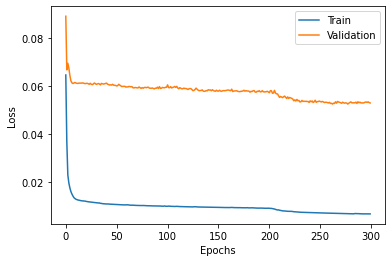

In [134]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

Predict the result

In [135]:
predict = model.predict(X_train)
print(predict.shape)
print(X_train.shape)

49/49 [==============================] - 0s 3ms/step
(1568, 16, 1782)
(1568, 16, 1782)


Change the format of the data

In [137]:
forcast =  pd.DataFrame({},columns=valid_samples_df.columns)[1]
for i in predict:
    forcast = forcast.append(pd.DataFrame(s.inverse_transform(i.reshape((n_future, n_features))),
                                          columns=valid_samples_df.columns)[1].head(1))
forcast = forcast.append(pd.DataFrame(s.inverse_transform(predict[-1].reshape((n_future, n_features))),
                                          columns=valid_samples_df.columns)[1].tail(15))

forcast = forcast.reset_index(drop = True)
forcast = forcast.reset_index()
forcast["index"] +=16
forcast   

family,index,0,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,16,2.228210,0.001073,1.657142,1178.695190,-0.004039,250.690399,0.085421,461.007599,485.891083,...,0.007669,324.390228,71.791862,0.084293,0.154015,215.544281,39.092541,1037.664917,-0.000698,26.322760
1,17,2.218823,0.000559,1.588502,1177.896973,-0.001581,248.664566,-0.004257,449.760437,487.877045,...,0.019927,331.365173,71.603439,0.049088,-0.010804,220.263687,39.438503,992.020081,0.001874,27.002964
2,18,1.929483,0.000139,1.447472,1155.336914,-0.000007,242.195663,-0.040693,429.475281,477.725433,...,-0.039349,296.967590,70.595451,-0.014149,-0.039098,201.921570,37.887543,996.678589,0.001069,25.914936
3,19,1.808213,0.000329,1.341294,1127.915161,-0.005162,238.615997,-0.025039,417.652557,471.279327,...,-0.096023,261.692383,70.289261,-0.103225,-0.028062,188.518219,36.364544,993.361450,0.001737,23.995512
4,20,1.963988,-0.000353,1.464719,1138.623779,-0.010279,240.437576,0.037986,431.669250,469.342773,...,-0.019467,255.519943,71.764191,-0.059276,0.102631,187.283417,36.446793,1023.681458,0.001451,23.422028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,1594,3.757112,0.000271,3.275261,1808.789185,0.153817,331.656860,0.637088,548.308167,724.082520,...,5.352025,395.103333,88.113701,4.839925,4.950117,333.562744,46.649918,3016.024902,0.066817,33.787567
1579,1595,3.863561,0.001269,3.473616,1836.130127,0.164318,327.085571,0.627502,522.147034,732.914856,...,6.018499,415.407623,87.217384,5.133861,4.636043,341.599792,45.613487,2874.786133,0.078712,36.119064
1580,1596,3.454615,0.001717,3.214533,1687.812988,0.153041,283.795898,0.203088,450.685120,666.185120,...,5.542231,267.808411,84.457207,4.856015,3.395116,277.309692,38.014549,2563.897217,0.078222,29.396559
1581,1597,1.938052,0.001025,2.049674,1380.666504,0.133270,234.483322,-0.093057,341.279144,528.572693,...,3.534247,151.698166,68.996140,3.511261,2.361673,211.153534,26.647657,2245.435059,0.047552,18.161535


Prepare the prediction for final output

In [ ]:
train_last_16 = pd.DataFrame(s.inverse_transform(predict[1567].reshape((n_future, n_features))),columns=valid_samples_df.columns)
y_last_16 = pd.DataFrame(s.inverse_transform(y_train[1567].reshape((n_future, n_features))),columns=valid_samples_df.columns)
real_train_last_16 = train_samples_df.tail(16)

Prediction of one of the time series

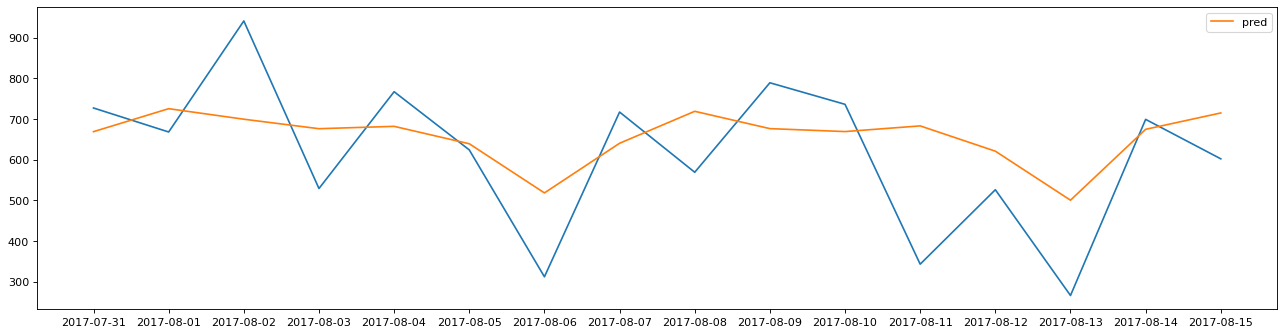

In [147]:
plt.figure(figsize=(20, 5), dpi=80)

plt.plot(real_last_16[1][8])
plt.plot(valid_pred[1][8], label="pred")

plt.legend()

RMSLE $\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$

MSLE $\frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2$

# Loss
predict the training and validation error

In [ ]:
predict = model.predict(X_train)
print(predict.shape)
train_pred = pd.DataFrame(s.inverse_transform(predict[-1].reshape((n_future, n_features))),columns=valid_samples_df.columns)
real_last_16 = train_samples_df.tail(16)
msle = tf.keras.losses.MeanSquaredLogarithmicError()
print("Teain MSLE",Root_Mean_Squared_Logarithmic_Error(real_last_16, train_pred).numpy())

x = np.concatenate((X_train, X_val), axis=0)
predict = model.predict(x)
print(predict.shape)
valid_pred = pd.DataFrame(s.inverse_transform(predict[-1].reshape((n_future, n_features))),columns=valid_samples_df.columns)
real_last_16 = valid_samples_df.tail(16)
msle = tf.keras.losses.MeanSquaredLogarithmicError()
print("Valid MSLE",Root_Mean_Squared_Logarithmic_Error(real_last_16, valid_pred).numpy())


# Submit the data
transform the data to the submission format, and submit to kaggle

In [150]:
sub_data = pd.read_csv(path+'sample_submission.csv', index_col=0)
sample_id = 3000888
## mapping ypredict to pivoted test data
for day_ith, day_ith_pred in submission_df.iterrows():
    #day_ith iteration, 16 days in totals
    #day_ith_pred, predicted data of 9 stores, 33 classes of good for each day
    #Iterate over DataFrame rows as (index, Series) pairs.
    # print(n_samples_per_day)
    # n_samples_per_day number of 
    for n_samples_per_day in range(len(day_ith_pred)): ## iterating the number of sample, from 0 to 1781, for 16 days
        #print(pivoted_test.iloc[[day_ith], [n_samples_per_day]])
        #sample_id = pivoted_test.iloc[[day_ith], [n_samples_per_day]].values[0][0] #total number of samples
        values= max(0,day_ith_pred.values[n_samples_per_day]) #price that is negative will be set to 0
        sub_data.at[sample_id, 'sales'] = values
        sample_id += 1

In [151]:
sub_data

,sales
id,
3000888,4.067669
3000889,0.000000
3000890,2.595315
3000891,1726.388428
3000892,0.083868
...,...
3029395,354.579254
3029396,105.031425
3029397,1441.516357


In [108]:
sub_data.to_csv('sub_20221028.csv')